# 🧠 LoRA vs Full Fine-tuning Analysis

## 📚 Import necessary libraries

In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration
BASE_DIR = 'outputs/cvt13_lora_vs_full_20251001_204331'
print(f"Analyzing: {BASE_DIR}\n")

Analyzing: outputs/cvt13_lora_vs_full_20251001_204331



## 📊 Data Loading

In [4]:
def extract_experiment_info(subdir_name):
    """Extract dataset, use_lora, and lr from directory name."""
    parts = subdir_name.rsplit('_', 2)
    if len(parts) != 3:
        return 'unknown', False, 1e-4
    
    dataset = parts[0]
    exp_type = parts[1]
    use_lora = exp_type == 'lora'
    
    lr_part = parts[2]
    lr = float(lr_part.replace('lr', '')) if lr_part.startswith('lr') else 1e-4
    
    return dataset, use_lora, lr

def load_results_from_directory(subdir_path, subdir_name):
    """Load all results from a single experiment directory."""
    config_path = os.path.join(subdir_path, 'config.json')
    history_path = os.path.join(subdir_path, 'training_history.csv')
    test_path = os.path.join(subdir_path, 'test_results.csv')
    
    if not os.path.exists(config_path) or not os.path.exists(history_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    history_df = pd.read_csv(history_path)
    test_df = pd.read_csv(test_path) if os.path.exists(test_path) else None
    
    dataset, use_lora, lr = extract_experiment_info(subdir_name)
    
    train_final = history_df[history_df['phase'] == 'train'].iloc[-1]
    
    results = {
        'experiment': subdir_name,
        'dataset': dataset,
        'use_lora': use_lora,
        'lr': config['learning_rate'],
        'epochs': config['epochs'],
        'total_params': config['model_parameters']['total'],
        'trainable_params': config['model_parameters']['trainable'],
        'trainable_pct': config['model_parameters']['trainable_percentage'],
        'train_loss': train_final['loss'],
        'train_acc': train_final['avg_accuracy'],
        'train_f1': train_final['avg_f1'],
        'avg_time_per_epoch': history_df[history_df['phase'] == 'train']['time_seconds'].mean(),
    }
    
    if 'lora_config' in config:
        results['lora_r'] = config['lora_config']['r']
        results['lora_alpha'] = config['lora_config']['alpha']
    
    if test_df is not None and len(test_df) > 0:
        test_row = test_df.iloc[0]
        results.update({
            'test_loss': test_row['loss'],
            'test_acc': test_row['avg_accuracy'],
            'test_f1': test_row['avg_f1'],
            'test_precision': test_row['avg_precision'],
            'test_recall': test_row['avg_recall'],
            'test_auc': test_row['avg_auc']
        })
    
    return results

def load_all_experiments(base_dir):
    """Load all experiments."""
    all_results = []
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if not os.path.isdir(subdir_path) or subdir == 'base_model':
            continue
        results = load_results_from_directory(subdir_path, subdir)
        if results:
            all_results.append(results)
    
    df = pd.DataFrame(all_results)
    
    numeric_cols = ['lr', 'epochs', 'total_params', 'trainable_params', 'trainable_pct',
                    'train_loss', 'train_acc', 'train_f1', 'avg_time_per_epoch',
                    'test_loss', 'test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Load data
df = load_all_experiments(BASE_DIR)
print(f"Loaded {len(df)} experiments")

Loaded 18 experiments


In [5]:
df.head()

,experiment,dataset,use_lora,lr,epochs,total_params,trainable_params,trainable_pct,train_loss,train_acc,train_f1,avg_time_per_epoch,test_loss,test_acc,test_f1,test_precision,test_recall,test_auc,lora_r,lora_alpha
0,brics2025_full_lr1e-3,brics2025,False,0.0010,10,4940196,4940196,100.00,0.022014,0.995521,0.991392,3.796943,0.114014,0.985938,0.972210,0.972220,0.972596,0.998688,NaN,NaN
1,brics2025_full_lr5e-4,brics2025,False,0.0005,10,4940196,4940196,100.00,0.006115,0.998958,0.997956,4.043084,0.069953,0.987500,0.976263,0.976896,0.976317,0.999393,NaN,NaN
2,brics2025_full_lr1e-4,brics2025,False,0.0001,10,4940196,4940196,100.00,0.032089,0.995833,0.991813,4.033518,0.185883,0.979688,0.960606,0.962835,0.960289,0.997681,NaN,NaN
3,brics2025_lora_lr1e-3,brics2025,True,0.0010,10,4999592,59396,1.19,0.055915,0.992396,0.985185,2.345485,0.101526,0.982031,0.965672,0.966638,0.966094,0.997027,8.0,16.0
4,brics2025_lora_lr5e-4,brics2025,True,0.0005,10,4999592,59396,1.19,0.089252,0.983437,0.967674,2.407549,0.115416,0.980469,0.962792,0.963634,0.963381,0.995679,8.0,16.0


## 📈 Summary Statistics

In [6]:
print("Summary Statistics: LoRA vs Full Fine-tuning")
print("="*80)

full_df = df[df['use_lora'] == False]
lora_df = df[df['use_lora'] == True]

metrics = ['test_acc', 'test_f1', 'test_auc', 'trainable_pct', 'avg_time_per_epoch']
summary = pd.DataFrame({
    'Full (mean)': full_df[metrics].mean(),
    'Full (std)': full_df[metrics].std(),
    'LoRA (mean)': lora_df[metrics].mean(),
    'LoRA (std)': lora_df[metrics].std(),
    'Difference': lora_df[metrics].mean() - full_df[metrics].mean()
})
print(summary)

Summary Statistics: LoRA vs Full Fine-tuning
                    Full (mean)  Full (std)  LoRA (mean)  LoRA (std)  \
test_acc               0.986690    0.007526     0.981240    0.017049   
test_f1                0.975738    0.015236     0.961776    0.035100   
test_auc               0.999004    0.000918     0.995366    0.006944   
trainable_pct        100.000000    0.000000     1.186667    0.005000   
avg_time_per_epoch     5.874653    2.454222     3.609201    1.475677   

                    Difference  
test_acc             -0.005449  
test_f1              -0.013961  
test_auc             -0.003638  
trainable_pct       -98.813333  
avg_time_per_epoch   -2.265452  


## 📊 Core Visualizations

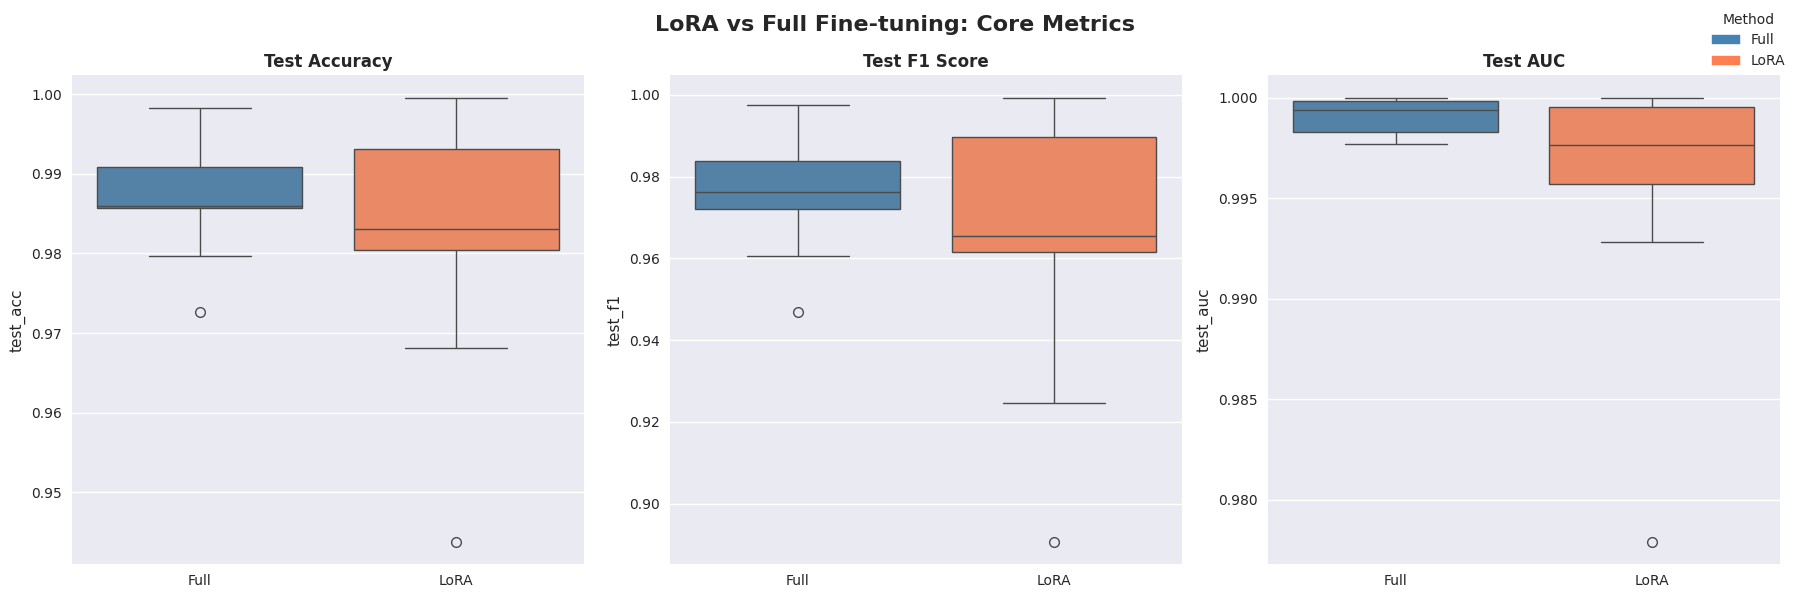

In [7]:
# Main Comparison: 3 Key Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('LoRA vs Full Fine-tuning: Core Metrics', fontsize=16, fontweight='bold')

metrics_plot = [
    ('test_acc', 'Test Accuracy'),
    ('test_f1', 'Test F1 Score'),
    ('test_auc', 'Test AUC')
]

for idx, (metric, title) in enumerate(metrics_plot):
    ax = axes[idx]
    sns.boxplot(data=df, x='use_lora', y=metric, ax=ax, palette=['steelblue', 'coral'])
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')
    ax.set_xticklabels(['Full', 'LoRA'])

# Add legend to the figure
handles = [plt.Rectangle((0,0),1,1, color='steelblue'), plt.Rectangle((0,0),1,1, color='coral')]
fig.legend(handles, ['Full', 'LoRA'], title='Method', loc='upper right')

plt.tight_layout()
plt.show()

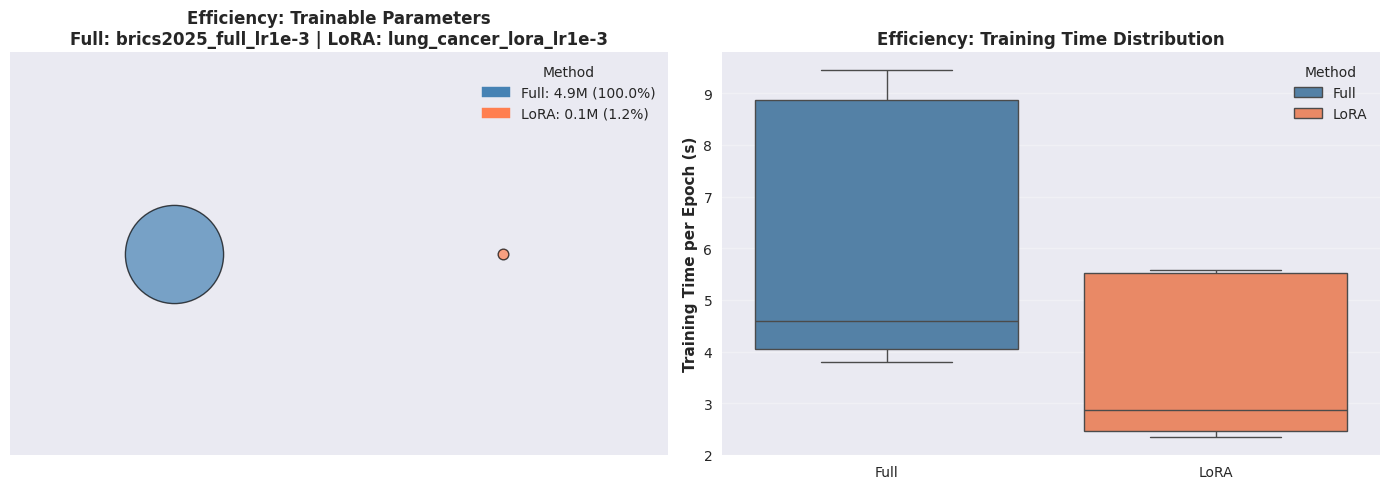

In [8]:
# Efficiency Trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Select specific runs: Full with highest trainable_pct, LoRA with lowest trainable_pct
full_example = full_df.loc[full_df['trainable_pct'].idxmax()]
lora_example = lora_df.loc[lora_df['trainable_pct'].idxmin()]

full_params = full_example['trainable_params'] / 1e6
full_pct = full_example['trainable_pct']
lora_params = lora_example['trainable_params'] / 1e6
lora_pct = lora_example['trainable_pct']

sizes = [full_pct * 50, lora_pct * 50]  # Scale for visibility
axes[0].scatter([0], [0], s=sizes[0], alpha=0.7, color='steelblue', edgecolors='black', linewidths=1)
axes[0].scatter([1], [0], s=sizes[1], alpha=0.7, color='coral', edgecolors='black', linewidths=1)
axes[0].set_xlim(-0.5, 1.5)
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title(f'Efficiency: Trainable Parameters\nFull: {full_example["experiment"]} | LoRA: {lora_example["experiment"]}', fontweight='bold')

# Custom legend with circles
import matplotlib.patches as mpatches
handles = [mpatches.Circle((0,0), radius=5, color='steelblue'), mpatches.Circle((0,0), radius=5, color='coral')]
labels = [f'Full: {full_params:.1f}M ({full_pct:.1f}%)', f'LoRA: {lora_params:.1f}M ({lora_pct:.1f}%)']
axes[0].legend(handles, labels, title='Method')
axes[0].grid(False)

# Time vs Accuracy: Boxplot
sns.boxplot(data=df, x='use_lora', y='avg_time_per_epoch', ax=axes[1], palette=['steelblue', 'coral'])
axes[1].set_xlabel('')
axes[1].set_xticklabels(['Full', 'LoRA'])
axes[1].set_ylabel('Training Time per Epoch (s)', fontweight='bold')
axes[1].set_title('Efficiency: Training Time Distribution', fontweight='bold')
axes[1].legend(['Full', 'LoRA'], title='Method')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

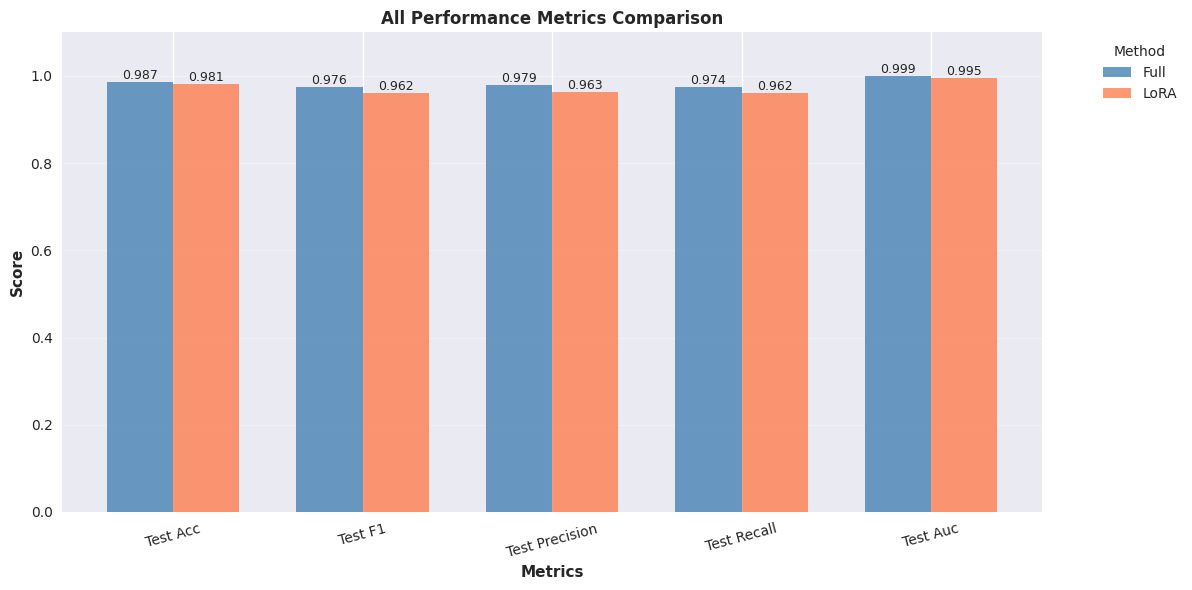

In [9]:
# All Metrics Comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics_compare = ['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
x = np.arange(len(metrics_compare))
width = 0.35

full_means = [full_df[m].mean() for m in metrics_compare]
lora_means = [lora_df[m].mean() for m in metrics_compare]

bars1 = ax.bar(x - width/2, full_means, width, label='Full', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, lora_means, width, label='LoRA', color='coral', alpha=0.8)

ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('All Performance Metrics Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_compare], rotation=15)
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 🧮 Statistical Tests

In [10]:
# Compute paired differences (same dataset + lr)
tradeoff_results = []
for dataset in df['dataset'].unique():
    for lr in df['lr'].unique():
        full_row = df[(df['dataset']==dataset) & (df['lr']==lr) & (df['use_lora']==False)]
        lora_row = df[(df['dataset']==dataset) & (df['lr']==lr) & (df['use_lora']==True)]
        
        if len(full_row) > 0 and len(lora_row) > 0:
            # Compute overall score as average of key metrics
            full_metrics = ['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
            lora_metrics = ['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
            full_overall = full_row[full_metrics].iloc[0].mean()
            lora_overall = lora_row[lora_metrics].iloc[0].mean()
            
            tradeoff_results.append({
                'full_overall': full_overall,
                'lora_overall': lora_overall,
                'full_time': full_row.iloc[0]['avg_time_per_epoch'],
                'lora_time': lora_row.iloc[0]['avg_time_per_epoch']
            })

if len(tradeoff_results) > 0:
    tradeoff_df = pd.DataFrame(tradeoff_results)
    
    t_stat_overall, p_overall = stats.ttest_rel(tradeoff_df['lora_overall'], tradeoff_df['full_overall'])
    t_stat_time, p_time = stats.ttest_rel(tradeoff_df['lora_time'], tradeoff_df['full_time'])
    
    print("Paired t-test (LoRA vs Full):")
    print(f"{'Metric':<15} {'t-stat':<10} {'p-value':<10} {'Significance'}")
    print("-" * 50)
    print(f"{'Overall Score':<15} {t_stat_overall:<10.3f} {p_overall:<10.4f} {'*' if p_overall < 0.05 else '(ns)'}")
    print(f"{'Time':<15} {t_stat_time:<10.3f} {p_time:<10.4f} {'*' if p_time < 0.05 else '(ns)'}")

Paired t-test (LoRA vs Full):
Metric          t-stat     p-value    Significance
--------------------------------------------------
Overall Score   -1.435     0.1892     (ns)
Time            -6.874     0.0001     *


## ⚙️ Best configs for Full and LoRA

In [11]:
# Compute overall score for each experiment
df['overall_score'] = df[['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']].mean(axis=1)

# Group by config and compute average overall score per config
config_cols_full = ['lr']  # Assuming weight_decay is same, but if varies, add it
config_cols_lora = ['lr', 'lora_r', 'lora_alpha']  # Assuming lora_dropout is same

# For Full
full_configs = df[df['use_lora'] == False].groupby(config_cols_full)['overall_score'].mean().reset_index()
best_full_config = full_configs.loc[full_configs['overall_score'].idxmax()]

# For LoRA
lora_configs = df[df['use_lora'] == True].groupby(config_cols_lora)['overall_score'].mean().reset_index()
best_lora_config = lora_configs.loc[lora_configs['overall_score'].idxmax()]

# Print organized results
print("\n" + "="*80)
print("Best Configurations Based on Average Overall Score")
print("="*80)

print("\nBest Full Fine-tuning Config:")
print(f"  LR: {best_full_config['lr']}")
print(f"  Average Overall Score: {best_full_config['overall_score']:.4f}")

print("\nBest LoRA Config:")
print(f"  LR: {best_lora_config['lr']}")
print(f"  LoRA R: {best_lora_config['lora_r']}")
print(f"  LoRA Alpha: {best_lora_config['lora_alpha']}")
print(f"  Average Overall Score: {best_lora_config['overall_score']:.4f}")

print("\nAll Unique Full Configs (sorted by avg overall score):")
full_configs_sorted = full_configs.sort_values('overall_score', ascending=False)
for _, row in full_configs_sorted.iterrows():
    print(f"  LR: {row['lr']} | Avg Score: {row['overall_score']:.4f}")

print("\nAll Unique LoRA Configs (sorted by avg overall score):")
lora_configs_sorted = lora_configs.sort_values('overall_score', ascending=False)
for _, row in lora_configs_sorted.iterrows():
    print(f"  LR: {row['lr']} | R: {row['lora_r']} | Alpha: {row['lora_alpha']} | Avg Score: {row['overall_score']:.4f}")

# Print commands to run the best configs for each dataset
datasets = df['dataset'].unique()
model = "apple/mobilevit-small"
epochs = 10
batch_size = 32
num_processes = 2
num_workers = 4
seed = 42
optimizer = 'AdamW'

print("\n" + "="*80)
print("Commands to Run Best Configs (with plots and full output)")
print("="*80)

for dataset in datasets:
    data_dir = f"Data/{dataset.replace('brics2025', 'brain_tumor').replace('chest_xray', 'chest-xray').replace('lung_cancer', 'lung-cancer')}"  # Adjust based on Experiments.py
    
    # Full config command
    full_cmd = [
        "accelerate", "launch",
        f"--num_processes={num_processes}",
        "Train.py",
        "--data_dir", data_dir,
        "--model_name_or_path", model,
        f"--batch_size={batch_size}",
        f"--epochs={epochs}",
        f"--lr={best_full_config['lr']}",
        f"--optimizer={optimizer}",
        f"--num_workers={num_workers}",
        f"--seed={seed}",
        "--weight_decay=0.01",  # Added from Experiments.py
    ]
    
    # LoRA config command
    lora_cmd = [
        "accelerate", "launch",
        f"--num_processes={num_processes}",
        "Train.py",
        "--data_dir", data_dir,
        "--model_name_or_path", model,
        f"--batch_size={batch_size}",
        f"--epochs={epochs}",
        f"--lr={best_lora_config['lr']}",
        f"--optimizer={optimizer}",
        f"--num_workers={num_workers}",
        f"--seed={seed}",
        "--use_lora",
        f"--lora_r={int(best_lora_config['lora_r'])}",
        f"--lora_alpha={int(best_lora_config['lora_alpha'])}",
        "--lora_dropout=0.1",
    ]
    
    print(f"\nDataset: {dataset}")
    print(f"  Full Command: {' '.join(full_cmd)}")
    print(f"  LoRA Command: {' '.join(lora_cmd)}")

print("="*80)


Best Configurations Based on Average Overall Score

Best Full Fine-tuning Config:
  LR: 0.0005
  Average Overall Score: 0.9854

Best LoRA Config:
  LR: 0.001
  LoRA R: 8.0
  LoRA Alpha: 16.0
  Average Overall Score: 0.9836

All Unique Full Configs (sorted by avg overall score):
  LR: 0.0005 | Avg Score: 0.9854
  LR: 0.0001 | Avg Score: 0.9840
  LR: 0.001 | Avg Score: 0.9793

All Unique LoRA Configs (sorted by avg overall score):
  LR: 0.001 | R: 8.0 | Alpha: 16.0 | Avg Score: 0.9836
  LR: 0.0005 | R: 8.0 | Alpha: 16.0 | Avg Score: 0.9812
  LR: 0.0001 | R: 8.0 | Alpha: 16.0 | Avg Score: 0.9530

Commands to Run Best Configs (with plots and full output)

Dataset: brics2025
  Full Command: accelerate launch --num_processes=2 Train.py --data_dir Data/brain_tumor --model_name_or_path apple/mobilevit-small --batch_size=32 --epochs=10 --lr=0.0005 --optimizer=AdamW --num_workers=4 --seed=42 --weight_decay=0.01
  LoRA Command: accelerate launch --num_processes=2 Train.py --data_dir Data/brain_t

## 🚀 Push to the Hub

You can upload your trained or fine-tuned models to the Hugging Face Hub using the `Push_to_hub.py` script.
Below are examples for different model tasks.

---

**🧠 Brain Tumor (LoRA):**

```bash
python Push_to_hub.py \
  --output_dir outputs/[brain-tumor-output-dir] \
  --hub_model_id "<your_username>/mobilevit-small-lora-brain-tumor"
```

---

**🫁 Chest X-Ray (LoRA):**

```bash
python Push_to_hub.py \
  --output_dir outputs/[chest-xray-output-dir] \
  --hub_model_id "<your_username>/mobilevit-small-lora-chest-xray"
```

---

**🫀 Lung Cancer (LoRA):**

```bash
python Push_to_hub.py \
  --output_dir outputs/[lung-cancer-output-dir] \
  --hub_model_id "<your_username>/mobilevit-small-lora-lung-cancer"
```

---

💡 **Tip:**
Replace `<your_username>` with your actual Hugging Face username, and set `output_dir` to your model’s folder (the one containing the `model/` or `lora_adapter/`).